## Tutorial to build a AlexNet and train on CIFAR
#### Project 1, Data Science and Machine Learning Bootcamp

Some of the following implementation derive from:
[1] Official document of pytorch
[2] LRN implementation [here](https://zhuanlan.zhihu.com/p/29786939) 

In [1]:
# import necessary packages
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision
import torch.utils.data as data
import torch

### Instructor note
When you write your own project in PyTorch, there are a few things to pay attention to. In this tutorial, we will walk through the very basic steps:

    - build network
    - define loss and optim method
    - prepare dataset
    - write some function to control the training/validation flow, nested with visualization
    - other utilites

#### Build the network
We will create a class called `AlexNet` to wrap the network. It inherits the basic class `nn.Module` in PyTorch. The `__init__` method defines what type each layer belongs to (`Conv2d`, `ReLU`, etc.) and their configurations.

For this step, it is very important to have a graph in sketch first and compute in advance what the size of output maps would be. You need to resort to the [documents](http://pytorch.org/docs/stable/nn.html) if necessary.

The other important method is `forward`. It defines how the graph flows in a dynamic manner, meaning it creates the graph (and thus gradients) on the fly in each iteration. You can put some breakpoints here to debug your model (use pdb/pycharm, etc.). To use this function, simply write `output = model(input)`, here `model` stands for some instance you create from class `AlexNet`.

In [2]:
class AlexNet(nn.Module):
    """this is the pytorch version"""
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # use .view() to transfer shapes from conv layer to linear layer
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # why this operation?
        x = self.classifier(x)
        return x

In [3]:
# define the weight initialization here
def weight_init(m):
    if isinstance(m, nn.Conv2d):
        import math
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
    elif isinstance(m, nn.BatchNorm2d):
        # here weight and bias is the parameters in each layer
        m.weight.data.fill_(1)
        m.bias.data.zero_()

The flollowing network is exactly the same as the paper. 

In [4]:
class AlexNet_w_LRN(nn.Module):
    """this is exactly the same as paper goes"""
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, groups=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, padding=1, kernel_size=3),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        # use .view() to transfer shapes from conv layer to linear layer
        self.layer6 = nn.Sequential(
            nn.Linear(in_features=6*6*256, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        self.layer7 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        
        self.layer8 = nn.Linear(in_features=4096, out_features=num_classes)
        
    def forward(self, x):
        x = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        x = x.view(-1, 6*6*256)
        x = self.layer8(self.layer7(self.layer6(x)))
        
        return x

In [5]:
# For now, there is no official implementation in pytorch (as of Nov 2017).
# see the pull request here: https://github.com/pytorch/pytorch/issues/653
class LRN(nn.Module):
    def __init__(self, local_size=1, alpha=1.0, beta=0.75, ACROSS_CHANNELS=False):
        super(LRN, self).__init__()
        self.ACROSS_CHANNELS = ACROSS_CHANNELS
        if self.ACROSS_CHANNELS:
            self.average=nn.AvgPool3d(kernel_size=(local_size, 1, 1), 
                    stride=1,
                    padding=(int((local_size-1.0)/2), 0, 0)) 
        else:
            self.average=nn.AvgPool2d(kernel_size=local_size,
                    stride=1,
                    padding=int((local_size-1.0)/2))
        self.alpha = alpha
        self.beta = beta
    
    
    def forward(self, x):
        if self.ACROSS_CHANNELS:
            div = x.pow(2).unsqueeze(1)
            div = self.average(div).squeeze(1)
            div = div.mul(self.alpha).add(1.0).pow(self.beta) # '1.0' is the bias
        else:
            div = x.pow(2)
            div = self.average(div)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        x = x.div(div)
        return x

## Main pipeline

In [6]:
# set all the hyper-params here
batch_size = 4
model_type = 'pytorch'  # or 'paper'
epoch_size = 10

#### Load the dataset
Pytorch provides some popular datasets in `torchvision` package. Here we use CIFAR-10 as an example. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

To prepare a dataset, two steps should be considered. First the `transform` list. It will pre-process the input data based on the list (crop, flip, etc.). Second is to wrap the dataset into an iterator called `Dataloader`, it will prepare the dataset in a mini-batch manner, shuffle the dataset and other stuff (skip for now).

If you work on your own project in the future, it is definitely worthy looking into the details of the datasets source code [here](https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py), esp. the `__getitem__` method, in order to write customized one. 

In [7]:
# define dataset
transform = T.Compose([
                T.Resize(40),
                T.RandomCrop(32),
                T.RandomHorizontalFlip(),
                T.ToTensor(),
            ])
# change to your own root
# or simply put "./data" here
dataset = dset.CIFAR10(root='./data', train=True, transform=transform, download=True)
dataset.num_classes = 10
dataset.name = 'cifar10'
train_loader = data.DataLoader(dataset, batch_size, num_workers=2, shuffle=True)

test_set = dset.CIFAR10(root='./data', train=False, transform=transform)
test_loader = data.DataLoader(test_set, batch_size, num_workers=2, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


#### Side code: show some images for fun

 frog   cat   car   cat


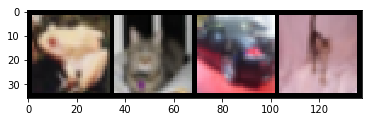

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### Define model, loss, optim

In [9]:
# define model
if model_type == 'pytorch':
    model = AlexNet(dataset.num_classes)
    model_info = 'use pytorch alexnet model'
elif model_type == 'paper':
    model = AlexNet_w_LRN(dataset.num_classes)
    model_info = 'use model in paper with LRN'
print(model_info)
# init the weights here
model.apply(weight_init)

use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.cuda()
    print('USE GPU')
else:
    print('USE CPU')

# define loss and optim
criterion = nn.CrossEntropyLoss(size_average=False)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))

use pytorch alexnet model
USE GPU


In [12]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_gpu:
            data, target = data.cuda(), target.cuda()   # put the Tensor on GPU
        data, target = Variable(data), Variable(target)
         
        optimizer.zero_grad()  # step1: clear the gradients
        output = model(data)   # step2: run the model and get outputs
        loss = criterion(output, target)   # step3: compute loss
        loss.backward()                    # step4: compute gradient using loss.backward()
        optimizer.step()                   # step5: update the parameter (w - \alpha * grad_w)
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
            

for epoch in range(epoch_size):
    train(epoch)
print('Training finished!')

Train Epoch: 0 [0/50000 (0%)]	Loss: 9.468506
Train Epoch: 0 [40/50000 (0%)]	Loss: 11.231109
Train Epoch: 0 [80/50000 (0%)]	Loss: 11.490110
Train Epoch: 0 [120/50000 (0%)]	Loss: 3.448144
Train Epoch: 0 [160/50000 (0%)]	Loss: 6.562239
Train Epoch: 0 [200/50000 (0%)]	Loss: 3.231769
Train Epoch: 0 [240/50000 (0%)]	Loss: 5.815630
Train Epoch: 0 [280/50000 (1%)]	Loss: 9.819461
Train Epoch: 0 [320/50000 (1%)]	Loss: 6.898457
Train Epoch: 0 [360/50000 (1%)]	Loss: 7.155758
Train Epoch: 0 [400/50000 (1%)]	Loss: 4.602345
Train Epoch: 0 [440/50000 (1%)]	Loss: 8.998138
Train Epoch: 0 [480/50000 (1%)]	Loss: 7.060830
Train Epoch: 0 [520/50000 (1%)]	Loss: 4.952301
Train Epoch: 0 [560/50000 (1%)]	Loss: 5.914195
Train Epoch: 0 [600/50000 (1%)]	Loss: 4.801013
Train Epoch: 0 [640/50000 (1%)]	Loss: 10.202130
Train Epoch: 0 [680/50000 (1%)]	Loss: 8.900969
Train Epoch: 0 [720/50000 (1%)]	Loss: 8.232727
Train Epoch: 0 [760/50000 (2%)]	Loss: 11.581240
Train Epoch: 0 [800/50000 (2%)]	Loss: 4.809340
Train Epoch: 

Train Epoch: 0 [7000/50000 (14%)]	Loss: 7.546973
Train Epoch: 0 [7040/50000 (14%)]	Loss: 10.296246
Train Epoch: 0 [7080/50000 (14%)]	Loss: 8.469522
Train Epoch: 0 [7120/50000 (14%)]	Loss: 7.145964
Train Epoch: 0 [7160/50000 (14%)]	Loss: 7.220522
Train Epoch: 0 [7200/50000 (14%)]	Loss: 9.293987
Train Epoch: 0 [7240/50000 (14%)]	Loss: 7.514903
Train Epoch: 0 [7280/50000 (15%)]	Loss: 6.817154
Train Epoch: 0 [7320/50000 (15%)]	Loss: 6.291779
Train Epoch: 0 [7360/50000 (15%)]	Loss: 7.756186
Train Epoch: 0 [7400/50000 (15%)]	Loss: 4.667734
Train Epoch: 0 [7440/50000 (15%)]	Loss: 6.025434
Train Epoch: 0 [7480/50000 (15%)]	Loss: 5.957823
Train Epoch: 0 [7520/50000 (15%)]	Loss: 4.331567
Train Epoch: 0 [7560/50000 (15%)]	Loss: 5.444976
Train Epoch: 0 [7600/50000 (15%)]	Loss: 6.831868
Train Epoch: 0 [7640/50000 (15%)]	Loss: 3.151561
Train Epoch: 0 [7680/50000 (15%)]	Loss: 5.357457
Train Epoch: 0 [7720/50000 (15%)]	Loss: 7.749092
Train Epoch: 0 [7760/50000 (16%)]	Loss: 7.117851
Train Epoch: 0 [780

Train Epoch: 0 [13720/50000 (27%)]	Loss: 5.383166
Train Epoch: 0 [13760/50000 (28%)]	Loss: 6.802917
Train Epoch: 0 [13800/50000 (28%)]	Loss: 8.931589
Train Epoch: 0 [13840/50000 (28%)]	Loss: 8.469539
Train Epoch: 0 [13880/50000 (28%)]	Loss: 4.961928
Train Epoch: 0 [13920/50000 (28%)]	Loss: 6.036089
Train Epoch: 0 [13960/50000 (28%)]	Loss: 4.109519
Train Epoch: 0 [14000/50000 (28%)]	Loss: 10.593351
Train Epoch: 0 [14040/50000 (28%)]	Loss: 11.699144
Train Epoch: 0 [14080/50000 (28%)]	Loss: 6.277892
Train Epoch: 0 [14120/50000 (28%)]	Loss: 4.123394
Train Epoch: 0 [14160/50000 (28%)]	Loss: 7.537880
Train Epoch: 0 [14200/50000 (28%)]	Loss: 12.561451
Train Epoch: 0 [14240/50000 (28%)]	Loss: 5.492022
Train Epoch: 0 [14280/50000 (29%)]	Loss: 4.015340
Train Epoch: 0 [14320/50000 (29%)]	Loss: 5.041958
Train Epoch: 0 [14360/50000 (29%)]	Loss: 8.949246
Train Epoch: 0 [14400/50000 (29%)]	Loss: 8.768802
Train Epoch: 0 [14440/50000 (29%)]	Loss: 6.176195
Train Epoch: 0 [14480/50000 (29%)]	Loss: 4.7225

Process Process-14:
Traceback (most recent call last):
  File "/home/hongyang/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/hongyang/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-13:
  File "/home/hongyang/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/hongyang/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/hongyang/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/datasets/cifar.py", line 122, in __getitem__
    img = self.transform(img)
  File "/home/hongyang/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py", line 42,

KeyboardInterrupt: 

You can get a sense of the gpu mode from my terminal:
![gpu shown in terminal](https://github.com/hli2020/alexnet-syngrad-pytorch/blob/master/gpu_mode.png)

It is really fast! AlexNet is small, only takes around 500 Mb memory (the first gpu).

#### Now get your hands dirty

What we do above is just the very basic of the alexnet on CIFAR-10. There are defenitely many aspects that you can explore. The very first thing after training is that, test the performance on the test data!

Write your own code below. For reference, see [here](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#test-the-network-on-the-test-data).

In [13]:
# write your own code about testing phase.

#### Try other components
Play with model to change other factors to further understand the workflow.

    - different learning strategies (adam, rmsprop, etc.)
    - bigger batch size really helpful?
    - remove FC and replace it with fully convolutional layers
    - data augmentation (e.g., multi-crop at test stage)
    - other network structures
    - compare time in GPU and CPU mode
    - other non-linearities
    - ...

In [14]:
# extensions and experiments here

If you don't have a GPU computer, don't worry. Let's do deep learning on cpu first. In the next project, we will learn to use Google AutoML Cloud, an online service with GPU support.